<a href="https://colab.research.google.com/github/OtavioC10/farmtech-na-era-da-cloud-computing/blob/main/OtavioCustodio_RM565606_pbl_fase5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 📈 Cap 1 - FarmTech na era da cloud computing


**Autores:**

*Otávio Custódio* — **RM:** *565606*

*Matheus Parra* **RM:** *561907*

*Tiago Alves Cordeiro* **RM:** *561791*

*Thiago Henrique Pereira de Almeida Santos* **RM:** *563327*

*Leandro Arthur Marinho Ferreira* - **RM:** *565240*


**Arquivo:** `OtavioCustodio_RM565606_pbl_fase4.ipynb`  
**Data de geração:** 03/09/2025


---



## 🎯 Objetivos
1. **Carregar e entender** a base `crop_yield.csv` (colunas em pt-BR).
2. Fazer **EDA**: qualidade dos dados, estatísticas, correlação e visualizações.
3. **Detectar outliers** (IQR e IsolationForest) e **explorar tendências** via **clusterização** (KMeans), incluindo análise de “elbow” e **silhouette**.
4. Treinar **5 modelos preditivos** distintos e comparar por **RMSE, MAE e R²**:
   - Regressão Linear
   - KNN Regressor
   - SVR (RBF)
   - Random Forest Regressor
   - Gradient Boosting Regressor
5. **Validação** com `RepeatedKFold` + `RandomizedSearchCV` (quando aplicável) e relatório final.



## ⚙️ Requisitos
- Python 3.9+
- `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `joblib`
- Coloque o arquivo **`crop_yield.csv`** na **raiz do projeto** ou na pasta **`./data/`**.



## 📦 Dados
**Esperado (nomes em português):**
- `Cultura`
- `Precipitação (mm dia 1)`
- `Umidade específica a 2 metros (g/kg)`
- `Umidade relativa a 2 metros (%)`
- `Temperatura a 2 metros (ºC)`
- `Rendimento` (t/ha)



In [39]:

# %% [code] Imports e utilidades
import os
import re
import json
import math
import warnings
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score
from sklearn.impute import SimpleImputer

# Modelos supervisonados (regressão)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from joblib import dump

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

def titulo(sec):
    print(f"\n{'='*10} {sec} {'='*10}")

def carregar_csv(caminhos):
    for p in caminhos:
        if Path(p).exists():
            print(f"✔️ Carregando dados de: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError("❌ Não encontrei 'crop_yield.csv'. Coloque-o na raiz do projeto ou em ./data/.")

def normalizar_coluna(s):
    # Remove acentos e padroniza
    import unicodedata
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def renomear_colunas_robusto(df):
    mapa_alvos = {
        "cultura": "Cultura",
        "precipitacao (mm dia 1)": "Precipitação (mm dia 1)",
        "umidade especifica a 2 metros (g/kg)": "Umidade específica a 2 metros (g/kg)",
        "umidade relativa a 2 metros (%)": "Umidade relativa a 2 metros (%)",
        "temperatura a 2 metros (c)": "Temperatura a 2 metros (ºC)",
        "temperatura a 2 metros (ºc)": "Temperatura a 2 metros (ºC)",
        "rendimento": "Rendimento",
    }
    # Normaliza atuais
    atuais_norm = {c: normalizar_coluna(c) for c in df.columns}
    inv = {}
    for k_norm, alvo in mapa_alvos.items():
        # tenta achar match
        cand = [c for c,n in atuais_norm.items() if n == k_norm]
        if cand:
            inv[cand[0]] = alvo
        else:
            # tenta por substrings sem unidades
            if k_norm.startswith("temperatura a 2 metros"):
                for c,n in atuais_norm.items():
                    if n.startswith("temperatura a 2 metros"):
                        inv[c] = "Temperatura a 2 metros (ºC)"
            if k_norm.startswith("umidade relativa a 2 metros"):
                for c,n in atuais_norm.items():
                    if n.startswith("umidade relativa a 2 metros"):
                        inv[c] = "Umidade relativa a 2 metros (%)"
            if k_norm.startswith("umidade especifica a 2 metros"):
                for c,n in atuais_norm.items():
                    if n.startswith("umidade especifica a 2 metros"):
                        inv[c] = "Umidade específica a 2 metros (g/kg)"
            if k_norm.startswith("precipitacao"):
                for c,n in atuais_norm.items():
                    if "precipitacao" in n or "chuva" in n:
                        inv[c] = "Precipitação (mm dia 1)"
    df = df.rename(columns=inv)
    return df

def avaliar_modelo(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


In [40]:

# %% [code] Carregamento dos dados
titulo("Carregamento")
possiveis_caminhos = ["crop_yield.csv", "./data/crop_yield.csv", "../data/crop_yield.csv"]
df = carregar_csv(possiveis_caminhos)
print(df.head())
print("\nFormato:", df.shape)

# Renomeia colunas de forma robusta (caso venham com variações)
df = renomear_colunas_robusto(df)
print("\nColunas após renomear:\n", df.columns.tolist())

df = df.rename(columns={"Yield": "Rendimento"})



========== Carregamento ==========
✔️ Carregando dados de: crop_yield.csv
           Crop  Precipitation (mm day-1)  \
0  Cocoa, beans                   2248.92   
1  Cocoa, beans                   1938.42   
2  Cocoa, beans                   2301.54   
3  Cocoa, beans                   2592.35   
4  Cocoa, beans                   2344.72   

   Specific Humidity at 2 Meters (g/kg)  Relative Humidity at 2 Meters (%)  \
0                                 17.72                              83.40   
1                                 17.54                              82.11   
2                                 17.81                              82.79   
3                                 17.61                              85.07   
4                                 17.61                              84.12   

   Temperature at 2 Meters (C)  Yield  
0                        26.01  11560  
1                        26.11  11253  
2                        26.24   9456  
3                        


========== EDA — Qualidade e Estatísticas ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Rendimento                            156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB
None

Estatísticas descritivas (numéricas):
                                      count          mean           std  \
Precipitation (mm day-1)              156.0   2486.498974    289.457914   
Specific Humidity at 2 Meters (g/kg)  156.0     18

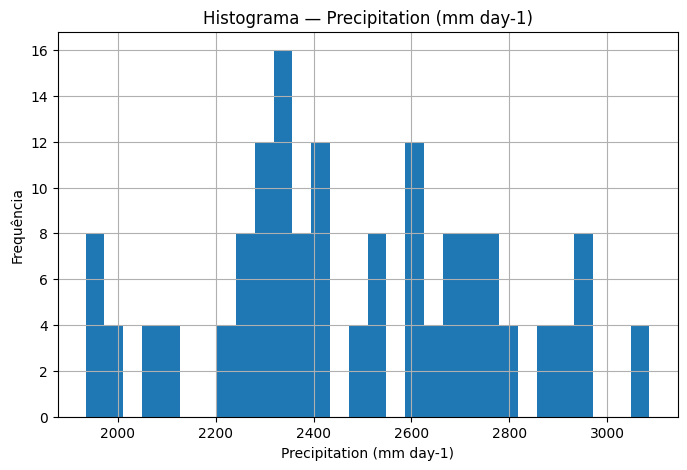

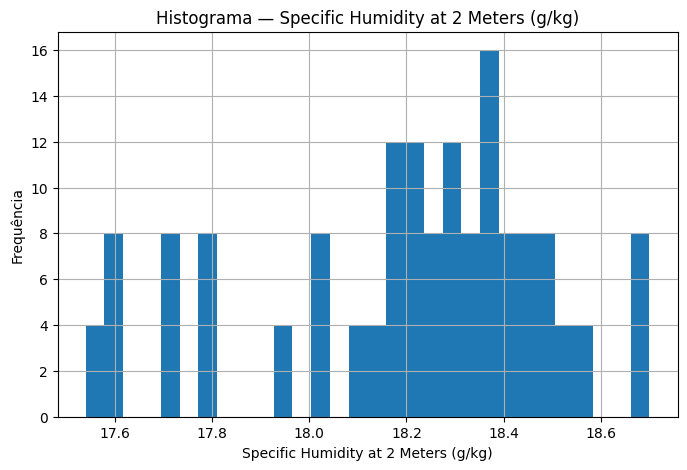

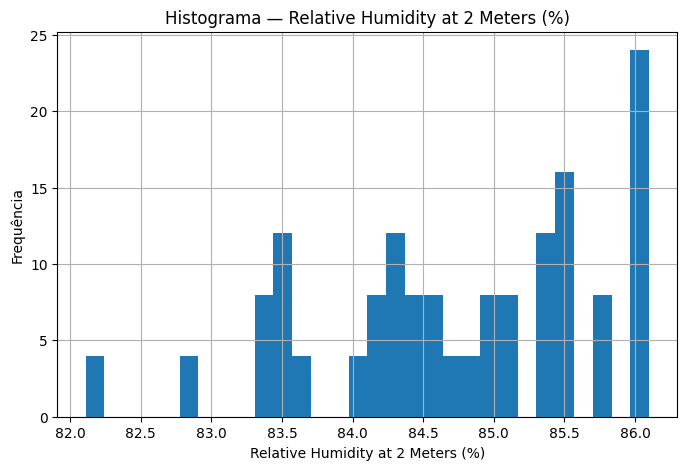

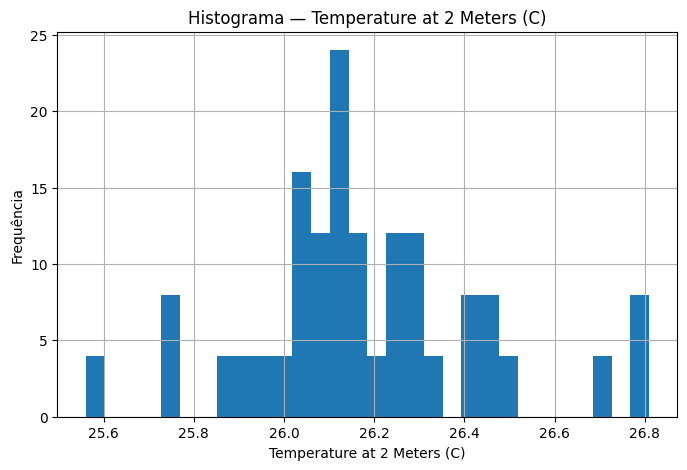

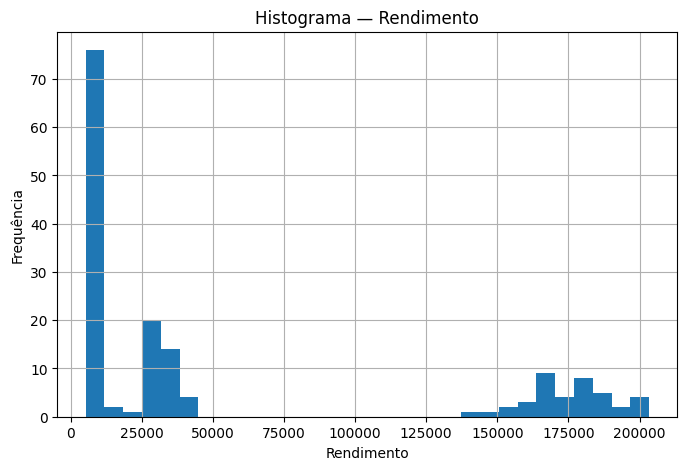

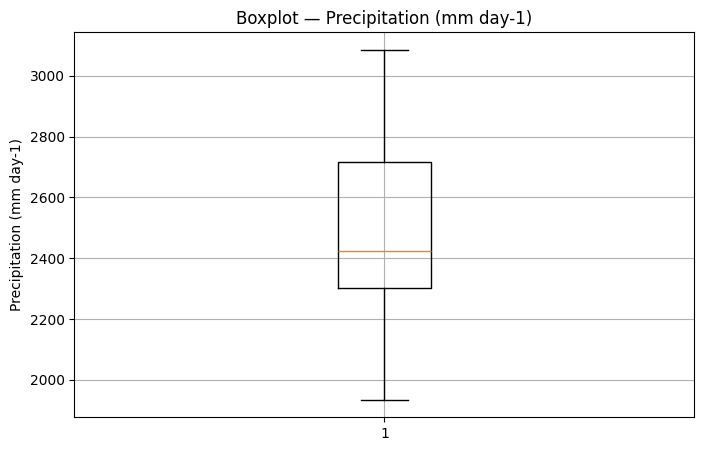

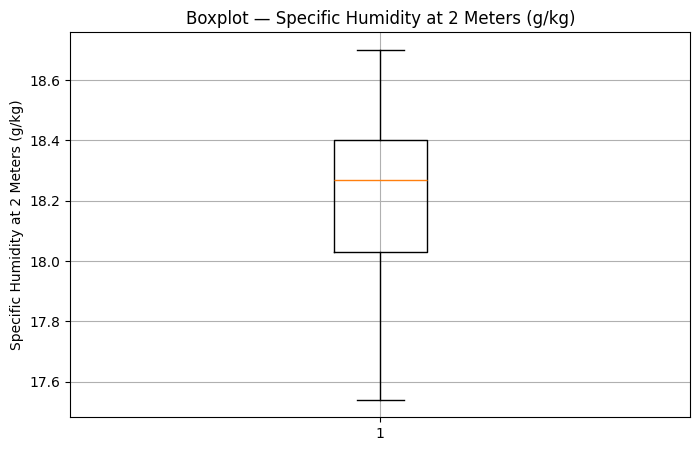

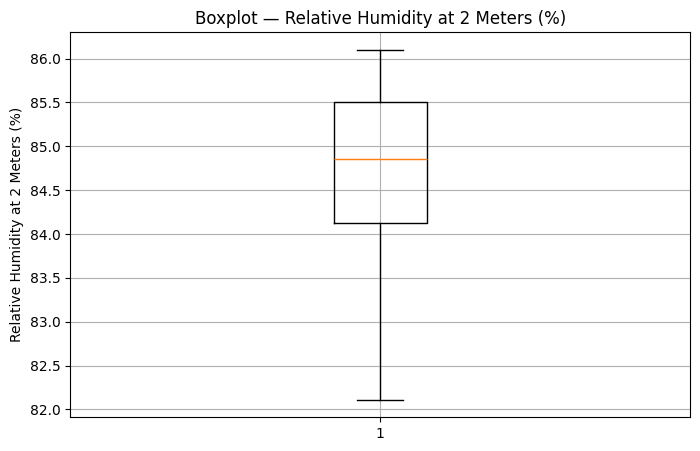

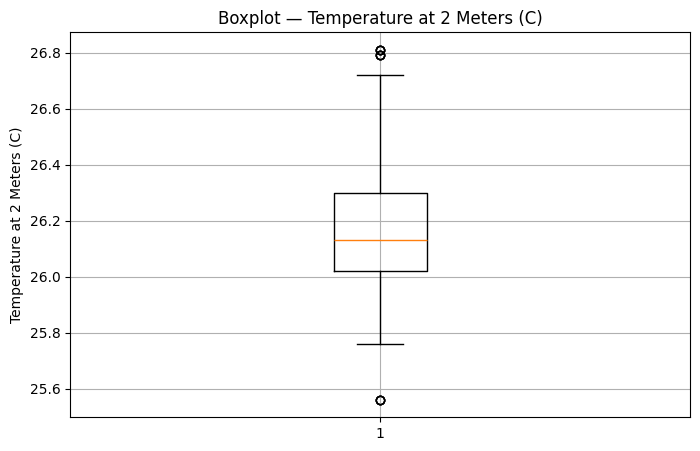

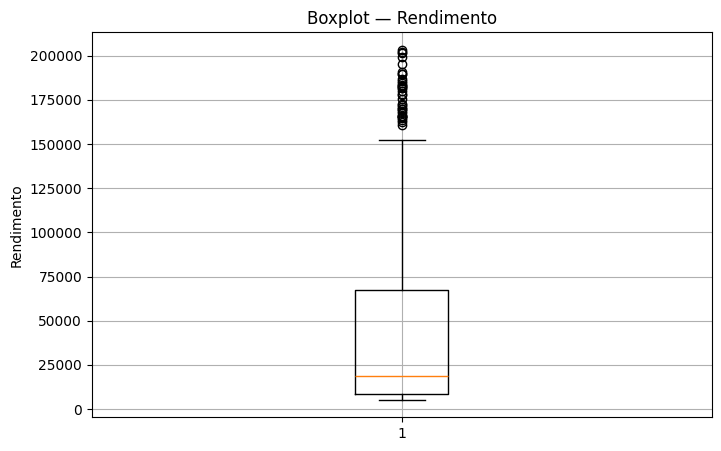

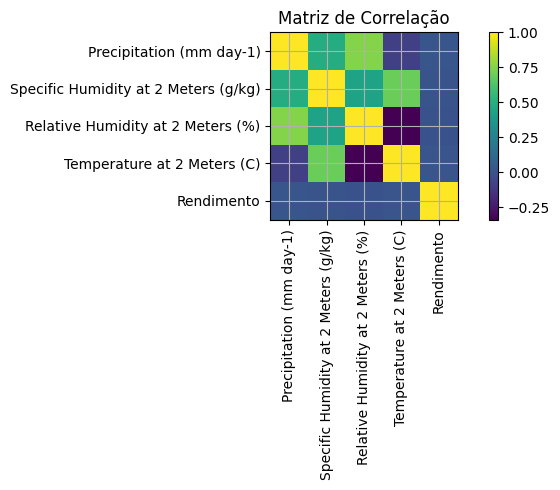


Correlação com 'Rendimento':
Rendimento                              1.000000
Precipitation (mm day-1)                0.018830
Temperature at 2 Meters (C)             0.013007
Specific Humidity at 2 Meters (g/kg)    0.012651
Relative Humidity at 2 Meters (%)       0.000008
Name: Rendimento, dtype: float64


In [38]:

# %% [code] EDA: visão geral e qualidade dos dados
titulo("EDA — Qualidade e Estatísticas")
print(df.info())
print("\nEstatísticas descritivas (numéricas):")
print(df.describe().T)

print("\nValores ausentes por coluna:")
print(df.isna().sum())

# Distribuição por Cultura
if "Cultura" in df.columns:
    contagem = df["Cultura"].value_counts(dropna=False)
    print("\nObservações por 'Cultura':")
    print(contagem)

# Seleciona colunas numéricas para gráficos
num_cols = [c for c in df.columns if df[c].dtype != "object" and c != "Cultura"]
num_cols = [c for c in num_cols if c != "Cultura"]

# Histograma para cada variável numérica
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col); plt.ylabel("Frequência")
    plt.show()

# Boxplots (numéricos)
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()

# Matriz de correlação (numéricos)
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title("Matriz de Correlação")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()

    if "Rendimento" in num_cols:
        print("\nCorrelação com 'Rendimento':")
        print(corr["Rendimento"].sort_values(ascending=False))


In [41]:

# %% [code] Detecção de outliers (IQR e IsolationForest)
titulo("Outliers — IQR e IsolationForest")

outlier_report = {}

# IQR por coluna numérica
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    mask = (df[col] < lim_inf) | (df[col] > lim_sup)
    outlier_report[col] = int(mask.sum())
    if mask.sum() > 0:
        print(f"[IQR] {col}: {mask.sum()} potenciais outliers (limites {lim_inf:.3f} a {lim_sup:.3f})")

# IsolationForest (multivariado nas features numéricas)
if len(num_cols) >= 2:
    iso = IsolationForest(random_state=RANDOM_SEED, contamination="auto")
    iso_labels = iso.fit_predict(df[num_cols].dropna())
    anomalias = (iso_labels == -1).sum()
    print(f"\n[IsolationForest] Possíveis anomalias multivariadas: {anomalias}")
else:
    print("\n[IsolationForest] Não foi possível rodar (menos de 2 features numéricas).")



========== Outliers — IQR e IsolationForest ==========
[IQR] Temperature at 2 Meters (C): 12 potenciais outliers (limites 25.600 a 26.720)
[IQR] Rendimento: 35 potenciais outliers (limites -80458.750 a 156305.250)

[IsolationForest] Possíveis anomalias multivariadas: 63


In [42]:

# %% [code] Pré-processamento (imputação, one-hot, escala)
titulo("Pré-processamento")

col_alvo = "Rendimento"
assert col_alvo in df.columns, "A coluna 'Rendimento' é obrigatória no dataset."

# Define features
features = [c for c in df.columns if c != col_alvo]
cat_cols = [c for c in features if df[c].dtype == "object"]
num_cols = [c for c in features if c not in cat_cols]

print("Colunas numéricas:", num_cols)
print("Colunas categóricas:", cat_cols)

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

X = df[features].copy()
y = df[col_alvo].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")



========== Pré-processamento ==========
Colunas numéricas: ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']
Colunas categóricas: ['Crop']
Train: (124, 5), Test: (32, 5)



========== Clusterização — KMeans (elbow & silhouette) ==========


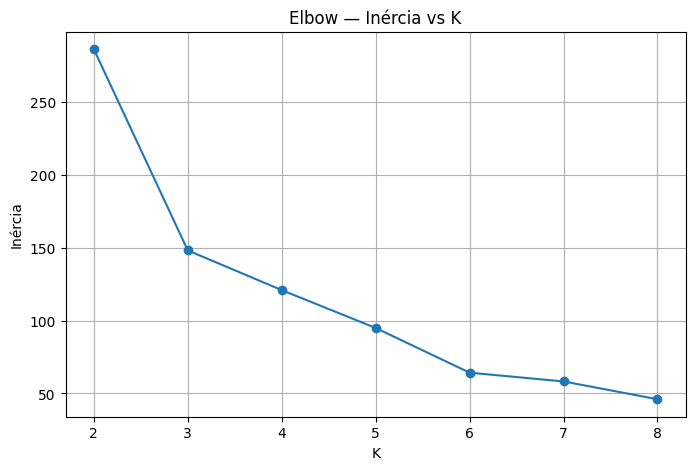

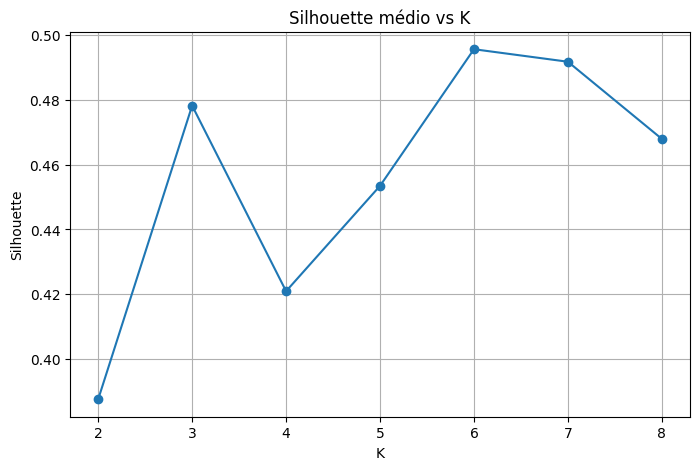

K selecionado (maior silhouette): 6 — valor 0.496


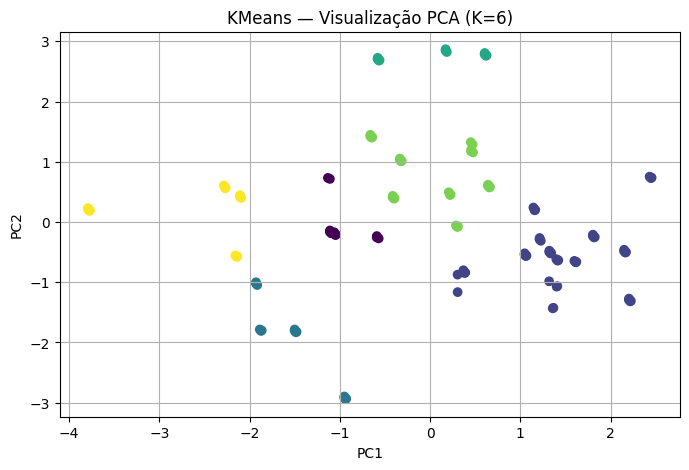


Perfil de Rendimento por cluster (train):
         count          mean           std
cluster                                   
5           13  64713.461538  77719.792507
1           46  64540.608696  75881.558605
2           14  61151.285714  77164.899783
3           11  59606.363636  71843.059555
4           27  54723.962963  72660.049471
0           13  34010.538462  52558.782030


In [43]:

# %% [code] Tendências via Clusterização (KMeans) + PCA 2D p/ visualização
titulo("Clusterização — KMeans (elbow & silhouette)")

# Pipeline para clustering (sem alvo)
cluster_pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("pca", PCA(n_components=2, random_state=RANDOM_SEED)),  # apenas para visualização
])

X_train_embedded = cluster_pipe.fit_transform(X_train)

inertias = []
silhs = []
ks = list(range(2, 9))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(X_train_embedded)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_train_embedded, labels)
    silhs.append(sil)

# Elbow plot (inércia)
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("Elbow — Inércia vs K")
plt.xlabel("K"); plt.ylabel("Inércia")
plt.show()

# Silhouette por K
plt.figure()
plt.plot(ks, silhs, marker="o")
plt.title("Silhouette médio vs K")
plt.xlabel("K"); plt.ylabel("Silhouette")
plt.show()

# Escolhe K pelo melhor silhouette
best_k = ks[int(np.argmax(silhs))]
print(f"K selecionado (maior silhouette): {best_k} — valor {max(silhs):.3f}")

kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_SEED)
labels = kmeans_final.fit_predict(X_train_embedded)

plt.figure()
plt.scatter(X_train_embedded[:,0], X_train_embedded[:,1], c=labels)
plt.title(f"KMeans — Visualização PCA (K={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Perfil médio de Rendimento por cluster (usando y_train alinhado por índice)
cluster_df = pd.DataFrame({
    "cluster": labels,
    "Rendimento": y_train.reset_index(drop=True)
})
perfil = cluster_df.groupby("cluster")["Rendimento"].agg(["count","mean","std"]).sort_values("mean", ascending=False)
print("\nPerfil de Rendimento por cluster (train):")
print(perfil)



========== Modelagem Supervisionada — 5 algoritmos ==========

--- Regressao Linear ---

--- KNN Regressor ---
Melhores hiperparâmetros: {'model__n_neighbors': 2}

--- SVR (RBF) ---
Melhores hiperparâmetros: {'model__gamma': np.float64(0.05455594781168517), 'model__epsilon': np.float64(0.29368421052631577), 'model__C': np.float64(100.0)}

--- Random Forest ---
Melhores hiperparâmetros: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 8}

--- Gradient Boosting ---
Melhores hiperparâmetros: {'model__subsample': 0.7, 'model__n_estimators': 400, 'model__max_depth': 5, 'model__learning_rate': np.float64(0.016681005372000592)}

Resultados no Teste (ordenado por RMSE):
                           RMSE           MAE        R2
Modelo                                                 
Regressao Linear    4394.165819   3132.796384  0.995022
Random Forest       4549.456673   2567.893397  0.994664
Gradient Boosting   6187.375734   3407.1011

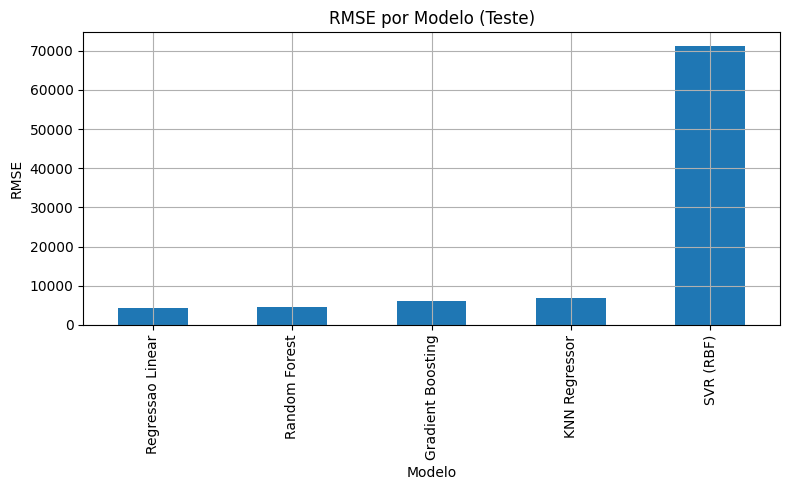


🏆 Melhor modelo (menor RMSE): Regressao Linear


In [33]:

# %% [code] Modelos e espaços de busca (hyperparams)
titulo("Modelagem Supervisionada — 5 algoritmos")

models = {
    "Regressao Linear": (
        LinearRegression(),
        {}  # sem hiperparâmetros
    ),
    "KNN Regressor": (
        KNeighborsRegressor(),
        {"model__n_neighbors": list(range(2, 31))}
    ),
    "SVR (RBF)": (
        SVR(),
        {
            "model__C": np.logspace(-2, 2, 20),
            "model__gamma": np.logspace(-3, 0, 20),
            "model__epsilon": np.linspace(0.01, 0.5, 20)
        }
    ),
    "Random Forest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "model__n_estimators": list(range(100, 601, 50)),
            "model__max_depth": [None] + list(range(3, 21, 1)),
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "model__n_estimators": list(range(100, 501, 50)),
            "model__learning_rate": np.logspace(-2, 0, 10),
            "model__max_depth": list(range(2, 8)),
            "model__subsample": [0.7, 0.85, 1.0]
        }
    )
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_SEED)

resultados = []
best_pipelines = {}

for nome, (est, grid) in models.items():
    print(f"\n--- {nome} ---")
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", est)])

    if grid:
        # Busca aleatória (rápida) — ajusta n_iter conforme tamanho do grid
        n_iter = min(40, sum(len(v) if hasattr(v, "__len__") else 20 for v in grid.values()))
        busca = RandomizedSearchCV(
            pipe, param_distributions=grid, n_iter=n_iter,
            scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1,
            random_state=RANDOM_SEED, verbose=0
        )
        busca.fit(X_train, y_train)
        melhor = busca.best_estimator_
        best_params = busca.best_params_
        print("Melhores hiperparâmetros:", best_params)
    else:
        melhor = pipe.fit(X_train, y_train)
        best_params = {}

    # Avaliação no conjunto de teste
    y_pred = melhor.predict(X_test)
    m = avaliar_modelo(y_test, y_pred)
    m["Modelo"] = nome
    resultados.append(m)
    best_pipelines[nome] = melhor

# Tabela de resultados
res_df = pd.DataFrame(resultados).set_index("Modelo").sort_values("RMSE")
print("\nResultados no Teste (ordenado por RMSE):")
print(res_df)

# Gráfico RMSE por modelo
plt.figure()
res_df["RMSE"].plot(kind="bar")
plt.title("RMSE por Modelo (Teste)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

melhor_modelo_nome = res_df.index[0]
print(f"\n🏆 Melhor modelo (menor RMSE): {melhor_modelo_nome}")
modelo_final = best_pipelines[melhor_modelo_nome]


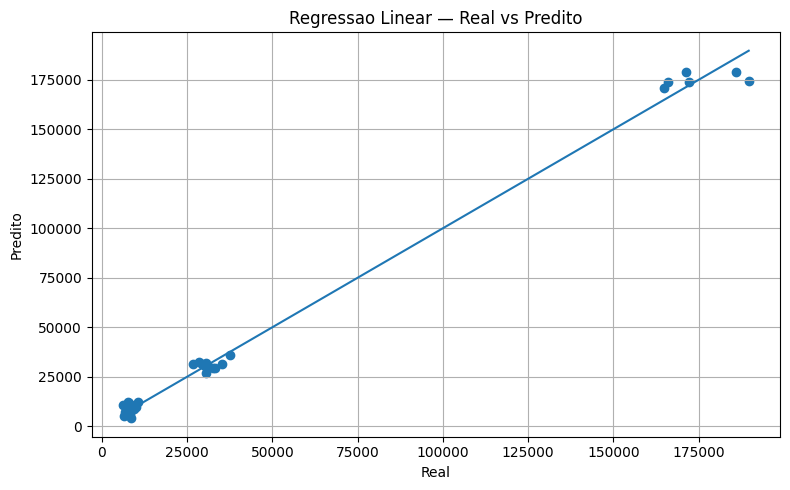

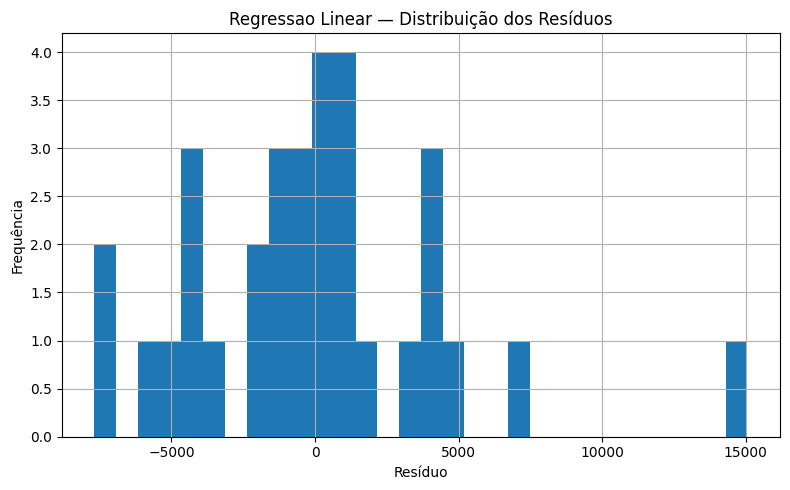

In [44]:

# %% [code] Análise de resíduos e Predito vs Real (melhor modelo)
y_pred_best = modelo_final.predict(X_test)

# Predito vs Real
plt.figure()
plt.scatter(y_test, y_pred_best)
plt.xlabel("Real"); plt.ylabel("Predito")
plt.title(f"{melhor_modelo_nome} — Real vs Predito")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])  # linha 45º
plt.tight_layout()
plt.show()

# Resíduos
residuos = y_test - y_pred_best
plt.figure()
plt.hist(residuos, bins=30)
plt.title(f"{melhor_modelo_nome} — Distribuição dos Resíduos")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


In [45]:

# %% [code] Persistência do modelo final (opcional)
Path("models").mkdir(exist_ok=True)
model_path = Path("models") / "modelo_final.joblib"
dump(modelo_final, model_path)
print(f"✔️ Modelo salvo em: {model_path.resolve()}")


✔️ Modelo salvo em: /content/models/modelo_final.joblib



## ✅ Conclusões e Próximos Passos
- Exploramos o dataset, verificamos qualidade, **distribuições** e **correlações**.
- Detectamos **outliers** por coluna (IQR) e **anomalias multivariadas** com IsolationForest.
- Identificamos **tendências** via **clusterização KMeans** com seleção de K por **silhouette** e avaliamos o perfil de rendimento por cluster.
- Treinamos **5 modelos** de regressão e comparamos via **RMSE, MAE e R²** no *hold-out* de teste.
- Persistimos o **melhor modelo** em `models/modelo_final.joblib` para uso futuro.

